# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    # add_dev train
    #add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    #add_dev_paths = sorted(add_dev_paths)
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths# + add_train_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(f"{TB_DIR}/{machine_type}", exist_ok=True)
    tb_log_dir = f"{TB_DIR}/{machine_type}"
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['param']['sample_rate'],
                window_size=config['param']['window_size'],
                hop_size=config['param']['hop_size'],
                mel_bins=config['param']['mel_bins'],
                fmin=config['param']['fmin'],
                fmax=config['param']['fmax'])
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_ROOT'])
    net.load_state_dict(pretrained_dict, strict=False)
    #net.load_state_dict(torch.load(config['IO_OPTION']['PREMODEL_ROOT']), strict=False)
    num_epochs = config['param']['num_epochs']
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    criterion = nn.MSELoss()
    #num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, scheduler, num_epochs, writer)
    # output
    #model = history['model']
    #model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    #torch.save(model.state_dict(), model_out_path)
    #logger.info('\n success:{0} \n'.format(machine_type) + \
    #                'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

2021-03-12 20:46:44,602 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-03-12 20:46:44,629 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-12 20:46:44,631 - 00_train.py - INFO - TRAINING
  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 24/24 [01:06<00:00,  2.77s/it]


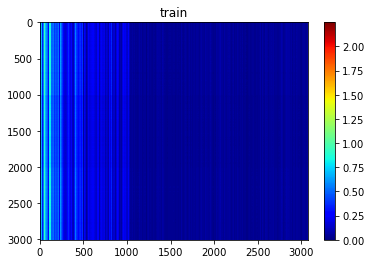

100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


torch.Size([600, 3072])


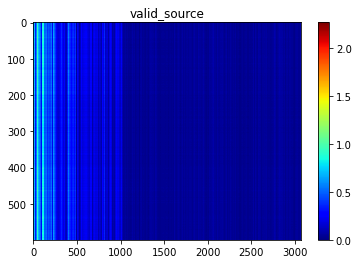

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


torch.Size([600, 3072])


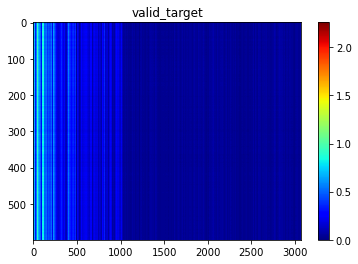

2021-03-12 20:48:21,831 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-03-12 20:48:21,832 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-12 20:48:21,836 - 00_train.py - INFO - TRAINING


elapsed time: 97.228971720 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 24/24 [01:08<00:00,  2.85s/it]


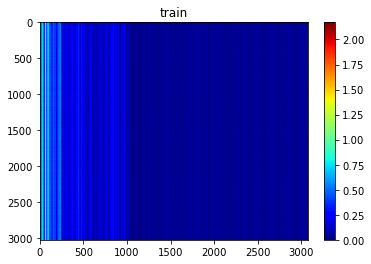

100%|██████████| 6/6 [00:17<00:00,  2.88s/it]


torch.Size([762, 3072])


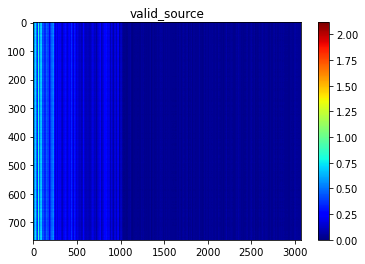

100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


torch.Size([645, 3072])


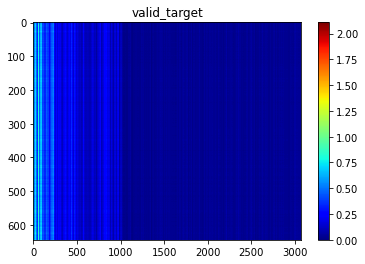

2021-03-12 20:50:04,845 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-03-12 20:50:04,846 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-12 20:50:04,848 - 00_train.py - INFO - TRAINING


elapsed time: 103.012554407 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 24/24 [01:08<00:00,  2.84s/it]


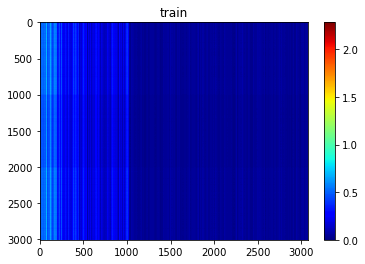

100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


torch.Size([600, 3072])


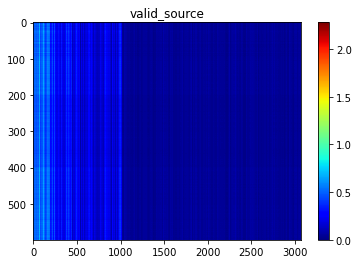

100%|██████████| 5/5 [00:13<00:00,  2.73s/it]


torch.Size([600, 3072])


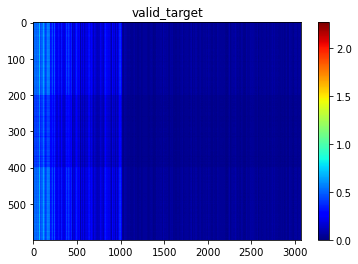

2021-03-12 20:51:42,695 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-03-12 20:51:42,696 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-12 20:51:42,720 - 00_train.py - INFO - TRAINING


elapsed time: 97.848821402 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 24/24 [01:07<00:00,  2.79s/it]


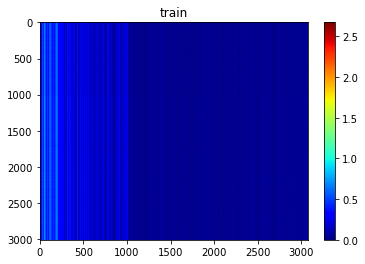

100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


torch.Size([612, 3072])


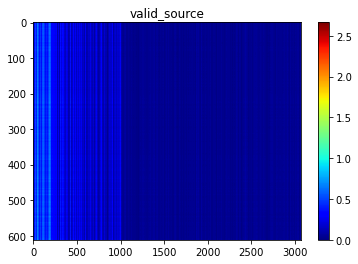

100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


torch.Size([602, 3072])


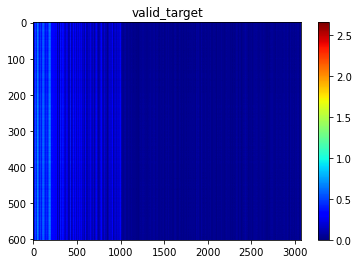

2021-03-12 20:53:18,922 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-03-12 20:53:18,923 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-12 20:53:18,925 - 00_train.py - INFO - TRAINING


elapsed time: 96.226417542 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 24/24 [01:03<00:00,  2.65s/it]


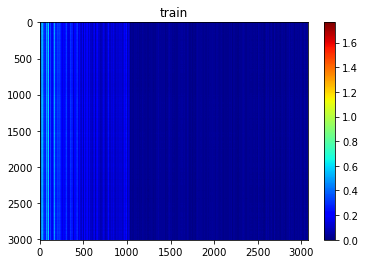

100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


torch.Size([600, 3072])


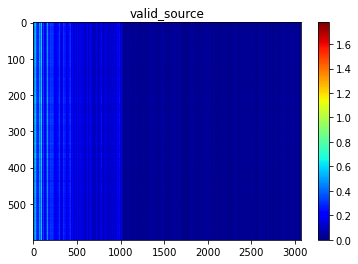

100%|██████████| 5/5 [00:13<00:00,  2.61s/it]


torch.Size([600, 3072])


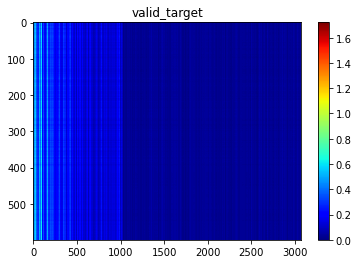

2021-03-12 20:54:51,095 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-03-12 20:54:51,117 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-12 20:54:51,119 - 00_train.py - INFO - TRAINING


elapsed time: 92.172076702 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 24/24 [01:04<00:00,  2.69s/it]


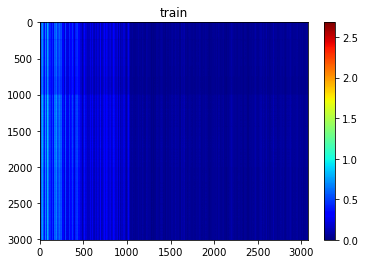

100%|██████████| 5/5 [00:12<00:00,  2.59s/it]


torch.Size([600, 3072])


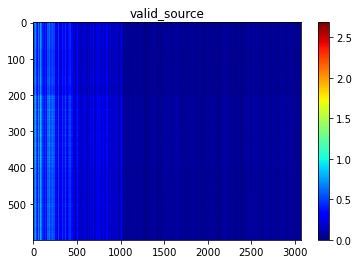

100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


torch.Size([600, 3072])


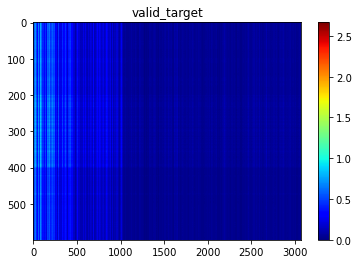

2021-03-12 20:56:24,085 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-03-12 20:56:24,086 - 00_train.py - INFO - MAKE DATA_LOADER
2021-03-12 20:56:24,088 - 00_train.py - INFO - TRAINING


elapsed time: 92.988978863 [sec]


  0%|          | 0/24 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 24/24 [01:04<00:00,  2.70s/it]


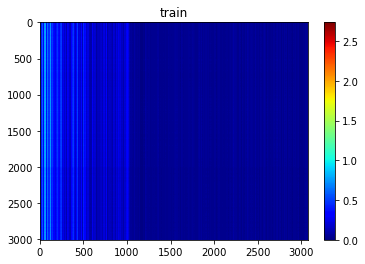

100%|██████████| 5/5 [00:14<00:00,  2.83s/it]


torch.Size([600, 3072])


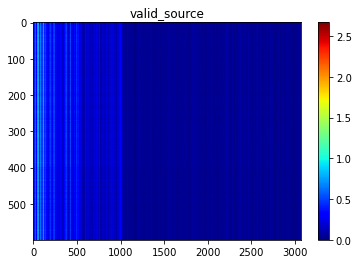

100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


torch.Size([600, 3072])


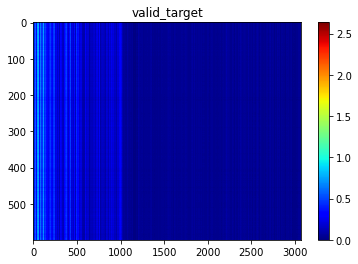

elapsed time: 95.218837500 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type, dev_paths)
    #with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    #    pickle.dump(history , file)

In [12]:
#history = run(machine_types[4], dev_paths)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)